# <span style='color: gold'>Customer Classification - RFM</span>

### Table of Contents
* <a href="#overview">Overview and goal</a>
* <a href="#wrangling">Data Wrangling</a>
* <a href="#cleaning">Data Cleaning</a>
* <a href="#eda">Exploratory Data Analysis</a>
* <a href="#model">Model</a>
* <a href="#conclusions">Conclusions</a>
* <a href="#possible-solutions">Solutions</a>


---
<a id='overview'></a>
### Overview
This analysis is done on the Online retail data which contains customer transactions of a multinational store based in the UK. The store deals majorly in gift-items and customers are predominantly wholesalers, hence the large purchases.


In this project, we'll be analysing data from over four hundred thousand purchases and segmenting the customers based on RFM. 

This will help the company at segmentation, retargeting and customer retention
The data features - 
- **InvoiceNo** - Invoice numbers containing letter 'C' indicate either cancelled purchases or returned products.
- **StockCode** - Item/product stock ID.
- **Description** - The product/item name.
- **Quantity** - Quantity of the item purchased.
- **InvoiceDate** - Date of Purchase.
- **UnitPrice** - Price per unit of the item purchased.
- **CustomerID** - Customer identification.
- **Country** - Country from which purchase was made.

An analysis of <a href="#returned"> returned products</a> is also done for more insights
 - Do feel free to comment your observations :)


### Concepts
#### RFM - Factors on which our customer analysis will be based
* **R** ~ Recency: Number of days since customer's last purchase
* **F** ~ Frequency: Number of transactions of the customer.
* **M** ~ Monetary: Total amount of transactions  (revenue contributed; total spent on our store)

### Loading dependencies

In [32]:
# required libraries for plots and numerical computations
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler # Standard Scaler
from sklearn.cluster import KMeans # KMeans

from scipy.cluster.hierarchy import linkage # Linkage
from scipy.cluster.hierarchy import dendrogram # Dendogram
from scipy.cluster.hierarchy import cut_tree # Cut Tree

import warnings
warnings.filterwarnings('ignore')

---
<a id='wrangling'></a>
### Data Wrangling
#### Importing our data

In [33]:
df = pd.read_csv('/kaggle/input/retail-purchases-dataset/Online Retail Data.csv')

In [34]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom


In [35]:
df.shape

(541909, 8)

---
<a id='cleaning'></a>
### Data Cleaning
#### Assessing our data

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


#### New column for revenue

In [37]:
df['Revenue'] = df['UnitPrice'] * df['Quantity']

In [38]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom,22.00


#### Renaming the columns

In [39]:
df.rename({'UnitPrice':'Unit Price', 'StockCode': 'Stock Code', 'CustomerID': 'Customer ID',
           'Quantity': 'Quantity Purchased', 'InvoiceDate':'Date of Purchase'}, 
          axis=1, inplace=True)

#### Changing the index range to start from 1

In [40]:
df.index = np.arange(1, len(df)+1)

#### Checking for null values

In [41]:
null_count = df.isnull().sum()
null_count

InvoiceNo                  0
Stock Code                 0
Description             1454
Quantity Purchased         0
Date of Purchase           0
Unit Price                 0
Customer ID           135080
Country                    0
Revenue                    0
dtype: int64

#### How much missing data in each column (in percentages)

In [42]:
df_null = round(100*(null_count)/len(df), 2)
df_null

InvoiceNo              0.00
Stock Code             0.00
Description            0.27
Quantity Purchased     0.00
Date of Purchase       0.00
Unit Price             0.00
Customer ID           24.93
Country                0.00
Revenue                0.00
dtype: float64

<AxesSubplot:>

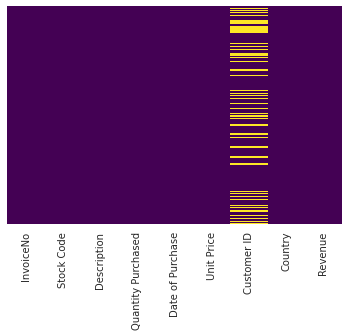

In [43]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [44]:
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])

In [45]:
df.head(1)

,InvoiceNo,Stock Code,Description,Quantity Purchased,Date of Purchase,Unit Price,Customer ID,Country,Revenue
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


---
<a id="eda"></a>
## EDA

 Creating two datasets; for all **retail** purchases and **returned** products

In [46]:
retail = df.dropna()

In [47]:
returned = df[df["InvoiceNo"].str.contains("C",na=False)]

##### The earliest purchased date; first date recorded and latest purchase recorded.

In [48]:
earliest_date = min(retail['Date of Purchase'])
latest_date = max(retail['Date of Purchase'])
print(f'Earliest date recorded: {earliest_date}, Latest recorded purchase: {latest_date}')

Earliest date recorded: 2010-12-01 08:26:00, Latest recorded purchase: 2011-12-09 12:50:00


<a id="returned"></a>
### Returned product analysis 

In [49]:
returned = df[df["InvoiceNo"].str.contains("C",na=False)]
returned.sort_values("Quantity Purchased").head(3)

,InvoiceNo,Stock Code,Description,Quantity Purchased,Date of Purchase,Unit Price,Customer ID,Country,Revenue
540423,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.6
61625,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6
4288,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,-280.8


In [50]:
returned.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity Purchased,9288.0,-29.885228,1145.786965,-80995.00,-6.00,-2.00,-1.00,-1.00
Unit Price,9288.0,48.393661,666.600430,0.01,1.45,2.95,5.95,38970.00
Customer ID,8905.0,14991.667266,1706.772357,12346.00,13510.00,14895.00,16393.00,18282.00
Revenue,9288.0,-96.556039,2039.905511,-168469.60,-17.70,-8.50,-3.70,-0.12


#### Most returned products

In [51]:
product_return_count = returned.groupby('Description')['InvoiceNo'].count()
product_return_count = product_return_count.reset_index()
product_return_count.columns = ['Product Name', 'Frequency of returns']
product_return_count.sort_values(by='Frequency of returns', ascending=False).head(5)

,Product Name,Frequency of returns
1093,Manual,244
1399,REGENCY CAKESTAND 3 TIER,181
1305,POSTAGE,126
887,JAM MAKING SET WITH JARS,87
538,Discount,77


#### Frequency of customer returns

In [52]:
f_returned = returned.groupby('Customer ID')['InvoiceNo'].count()
f_returned = f_returned.reset_index()
f_returned.rename({'InvoiceNo':'Frequency of returns'}, axis=1, inplace=True)

f_returned.sort_values(by='Frequency of returns',  axis=0,ascending=False).head(3)

,Customer ID,Frequency of returns
736,14911.0,226
1485,17841.0,136
1397,17511.0,113


#### Quantity of customer returns

In [53]:
q_returned = returned.groupby('Customer ID')['Quantity Purchased'].sum()
q_returned = q_returned.reset_index()
q_returned.columns = ['Customer ID', 'Quantity of customer returns']
q_returned['Quantity of customer returns'] = abs(q_returned['Quantity of customer returns'])
q_returned.head(3)

,Customer ID,Quantity of customer returns
0,12346.0,74215
1,12352.0,66
2,12359.0,10


#### Revenue lost to failed puirchases

In [54]:
r_returned = returned.groupby('Customer ID')['Revenue'].sum()
r_returned = r_returned.reset_index()
r_returned.columns = ['Customer ID', 'Revenue lost']
r_returned['Revenue lost'] = abs(r_returned['Revenue lost'])

print(f"About {round(r_returned['Revenue lost'].sum(), 2)} was lost to cancelled and failed purchases.")
r_returned.head(3)

About 611342.09 was lost to cancelled and failed purchases.


,Customer ID,Revenue lost
0,12346.0,77183.60
1,12352.0,960.63
2,12359.0,127.05


#### Failed purchases per month

In [55]:
returned_per_month = returned.set_index('Date of Purchase')['InvoiceNo'].resample('M').count()
# q_returned = returned.groupby('Date of Purchase')['Quantity Purchased'].sum()
returned_per_month = returned_per_month.reset_index()
returned_per_month.columns = ['Month', 'Returned/cancelled purchases']
returned_per_month.index = returned_per_month['Month']
returned_per_month.drop('Month', axis=1).T

Month,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31
Returned/cancelled purchases,728,701,475,699,559,621,711,685,668,805,1200,1076,360


In [56]:
f_q_returned = pd.merge(f_returned,q_returned, on='Customer ID', how='inner')
f_q_returned.head(3)

,Customer ID,Frequency of returns,Quantity of customer returns
0,12346.0,1,74215
1,12352.0,10,66
2,12359.0,6,10


## Completed purchases
### Factors R-F-M
<img src='customer_map.png'>
Recall the factors: Recency, Frequency and Monetary('Revenue' in this case)

In [57]:
retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity Purchased,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
Unit Price,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
Customer ID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0
Revenue,406829.0,20.401854,427.591718,-168469.6,4.20,11.10,19.50,168469.6


Since monetary is ready; as Revenue, we find the other two attributes for each customer

#### Recency ~ R

In [58]:
retail['Purchase recency'] = latest_date -retail['Date of Purchase']

In [59]:
##### Now to obtain the recency for each customer

In [60]:
rfm_r = retail.groupby('Customer ID')['Purchase recency'].min()
rfm_r = rfm_r.reset_index()
rfm_r.columns = ['Customer ID', 'Recency']
rfm_r.sample(3)

,Customer ID,Recency
911,13558.0,5 days 01:26:00
3823,17537.0,29 days 01:54:00
2393,15579.0,68 days 00:05:00


Since what we really need to know is how many days ago was the last purchase, we fetch days only

In [61]:
rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r.head(3)

,Customer ID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74


#### Frequency ~ F

In [62]:
rfm_f = retail.groupby('Customer ID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head(3)

,Customer ID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31


#### Monetary ~ M

In [63]:
rfm_m = retail.groupby('Customer ID')['Revenue'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['Customer ID', 'Monetary']
rfm_m.head(3)


,Customer ID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24


Now we can merge the *r-f-m* dataframes

In [64]:
rfm_r_f = pd.merge(rfm_r,rfm_f, on='Customer ID', how='inner')
rfm_r_f.head(3)

,Customer ID,Recency,Frequency
0,12346.0,325,2
1,12347.0,1,182
2,12348.0,74,31


In [65]:
### Note that we merged Recency and Frequency first because we cannot merge all three at once

In [66]:
rfm = pd.merge(rfm_r_f,rfm_m, on='Customer ID', how='inner')
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary'] #recall that monetary represents customer expenditure
rfm.set_index('Customer ID', inplace=True)
rfm.head(3)

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24


### Scoring with R-F-M
##### Scoring each customer based on Recency, Frequency, Monetary(Expenditure)

In [67]:
rfm["Recency Score"]  = pd.qcut(rfm["Recency"], 5, labels = [5, 4 , 3, 2, 1])
rfm["Frequency Score"]= pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["Monetary Score"] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])

rfm['RFM Score'] = rfm[["Recency Score", "Frequency Score", 'Monetary Score']].sum(axis = 1)

rfm['RFM Segment'] = rfm['Recency Score'].astype(str) + rfm['Frequency Score'].astype(str) + rfm['Monetary Score'].astype(str)
rfm
rfm.head(3)

,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,RFM Segment
Customer ID,,,,,,,,
12346.0,325,2,0.00,1,1,1,3,111
12347.0,1,182,4310.00,5,5,5,15,555
12348.0,74,31,1797.24,2,3,4,9,234


In [68]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Customer Segment'] = rfm['Recency Score'].astype(str) + rfm['Frequency Score'].astype(str)
rfm['Customer Segment'] = rfm['Customer Segment'].replace(seg_map, regex=True)

In [69]:
rfm.head(3)

,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,RFM Segment,Customer Segment
Customer ID,,,,,,,,,
12346.0,325,2,0.00,1,1,1,3,111,Hibernating
12347.0,1,182,4310.00,5,5,5,15,555,Champions
12348.0,74,31,1797.24,2,3,4,9,234,At Risk


### Outlier Analysis

Text(0.5, 0, 'Attributes')

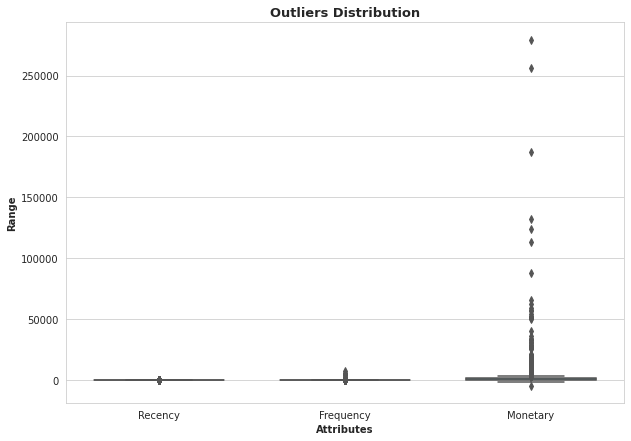

In [70]:
attributes = ['Recency', 'Frequency', 'Monetary']
# Since we need all except the customer ID columns
plt.rcParams['figure.figsize'] = [10,7]
sns.boxplot(data = rfm[attributes], orient="v", saturation=1, width=0.7)
plt.title("Outliers Distribution", fontsize = 13, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [71]:

# Removing (statistical) outliers for Recency
Q1 = rfm['Recency'].quantile(0.05)
Q3 = rfm['Recency'].quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm['Recency'] >= Q1 - 1.5 * IQR) & (rfm['Recency'] <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm['Frequency'].quantile(0.05)
Q3 = rfm['Frequency'].quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm['Frequency'] >= Q1 - 1.5 * IQR) & (rfm['Frequency'] <= Q3 + 1.5 * IQR)]


# Removing (statistical) outliers for Expenditure
Q1 = rfm['Monetary'].quantile(0.05)
Q3 = rfm['Monetary'].quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm['Monetary'] >= Q1 - 1.5 * IQR) & (rfm['Monetary'] <= Q3 + 1.5 * IQR)]


Text(0.5, 0, 'Factors')

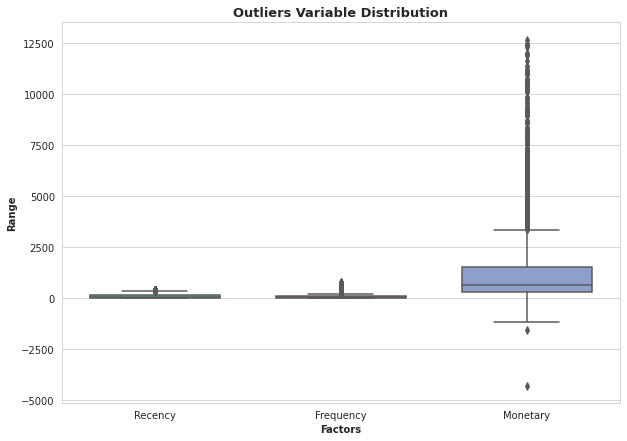

In [72]:
plt.rcParams['figure.figsize'] = [10,7]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 13, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Factors", fontweight = 'bold')

<AxesSubplot:xlabel='Customer Segment', ylabel='Recency'>

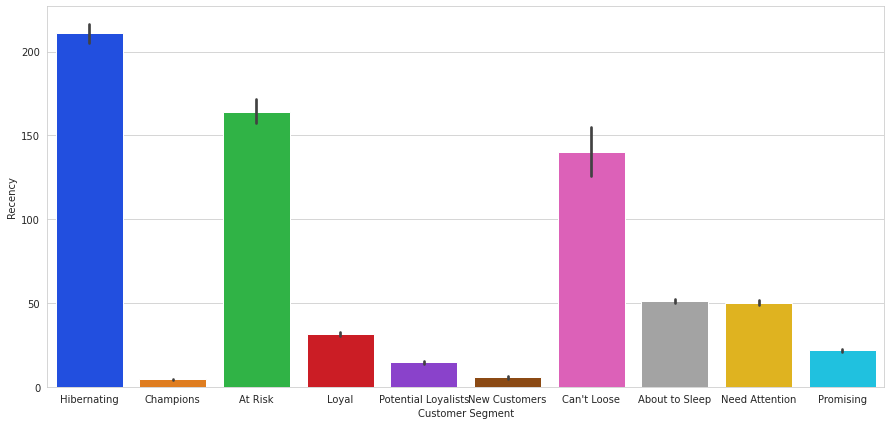

In [73]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = [15,7]
sns.barplot(x = rfm["Customer Segment"], y = rfm["Recency"], palette="bright")

<AxesSubplot:xlabel='Customer Segment', ylabel='Frequency'>

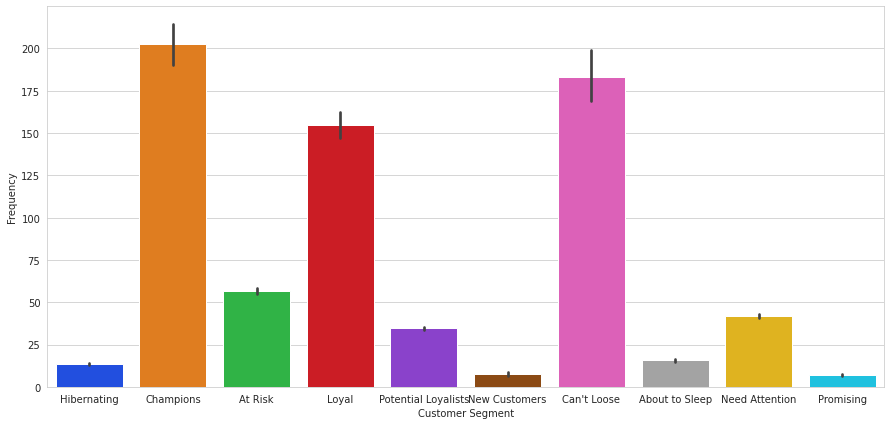

In [74]:
sns.barplot(x = rfm["Customer Segment"], y = rfm["Frequency"], palette="bright")

<AxesSubplot:xlabel='Customer Segment', ylabel='Monetary'>

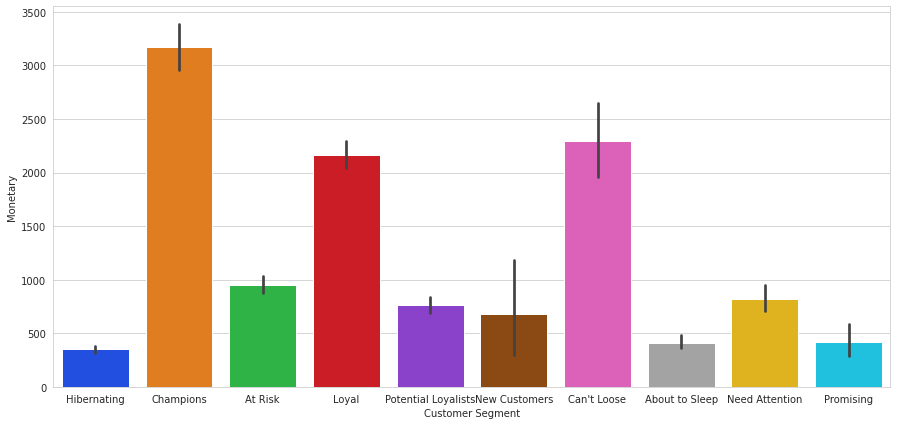

In [75]:
sns.barplot(x = rfm["Customer Segment"], y = rfm["Monetary"], palette="bright")

In [76]:
rfmStats = rfm[["Customer Segment","Recency","Frequency", "Monetary"]].groupby("Customer Segment").agg(["mean","median","count", "std"])

rfmStats

Recency                           Frequency         \
                           mean median count        std        mean median   
Customer Segment                                                             
About to Sleep        51.233645   51.0   321  10.959795   15.797508   15.0   
At Risk              164.136752  143.0   585  83.023691   56.668376   50.0   
Can't Loose          140.250000  116.5    84  70.327611  183.142857  157.0   
Champions              4.454713    3.0   541   3.285248  202.351201  153.0   
Hibernating          210.938028  211.0  1065  90.265762   13.358685   12.0   
Loyal                 31.417476   28.0   824  15.702984  154.542476  118.0   
Need Attention        50.242574   51.0   202  11.320987   41.693069   40.0   
New Customers          5.689655    6.5    58   3.288507    7.517241    8.5   
Potential Loyalists   14.593750   15.0   512   9.201112   34.509766   34.0   
Promising             21.714286   21.0    98   5.365026    7.122449    7.0   

                                          Monetary                  \
                    count         std         mean    median count   
Customer Segment                                                     
About to Sleep        321    8.029212   412.142928   306.450   321   
At Risk               585   23.335172   953.336103   689.950   585   
Can't Loose            84   71.642207  2291.069298  2028.225    84   
Champions             541  142.630066  3170.294861  2385.000   541   
Hibernating          1065    8.194016   348.591927   251.520  1065   
Loyal                 824  106.369553  2163.438653  1607.450   824   
Need Attention        202    8.495527   818.649015   662.910   202   
New Customers          58    3.916861   675.133103   204.000    58   
Potential Loyalists   512   12.800284   763.517187   574.425   512   
Promising              98    3.681285   418.561735   186.120    98   

                                  
                             std  
Customer Segment                  
About to Sleep        576.956080  
At Risk               998.862195  
Can't Loose          1670.422751  
Champions            2515.600571  
Hibernating           554.008621  
Loyal                1823.618297  
Need Attention        977.900328  
New Customers        1872.542211  
Potential Loyalists   861.191943  
Promising             803.446060

### Rescaling the attributes

Rescaling is done to give the variables a comparable scale. There are two rescaling conventions:

- *Standardisation (mean-0, sigma-1)*
    * hi
- *Min-Max scaling*
    * hi1
    
    
Here, we will use Standardisation Scaling.

In [77]:
rfm_df = rfm[['Recency', 'Frequency', 'Monetary']]

#### Instantiating the Standard Scaler

In [78]:
scaler = StandardScaler()

#### Fitting our data

In [79]:
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4290, 3)

In [80]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df_scaled.head(3)

,Recency,Frequency,Monetary
0,2.300765,-0.749872,-0.738835
1,-0.906903,1.041232,1.796627
2,-0.184188,-0.461305,0.318435


In [81]:
corr = rfm_df_scaled.corr()

<AxesSubplot:>

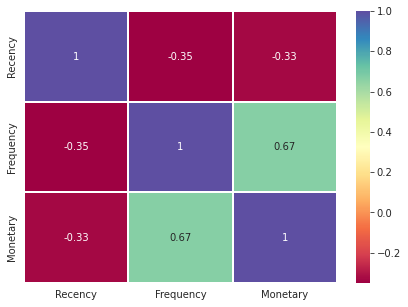

In [82]:
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='Spectral', linewidths = .2, annot=True)

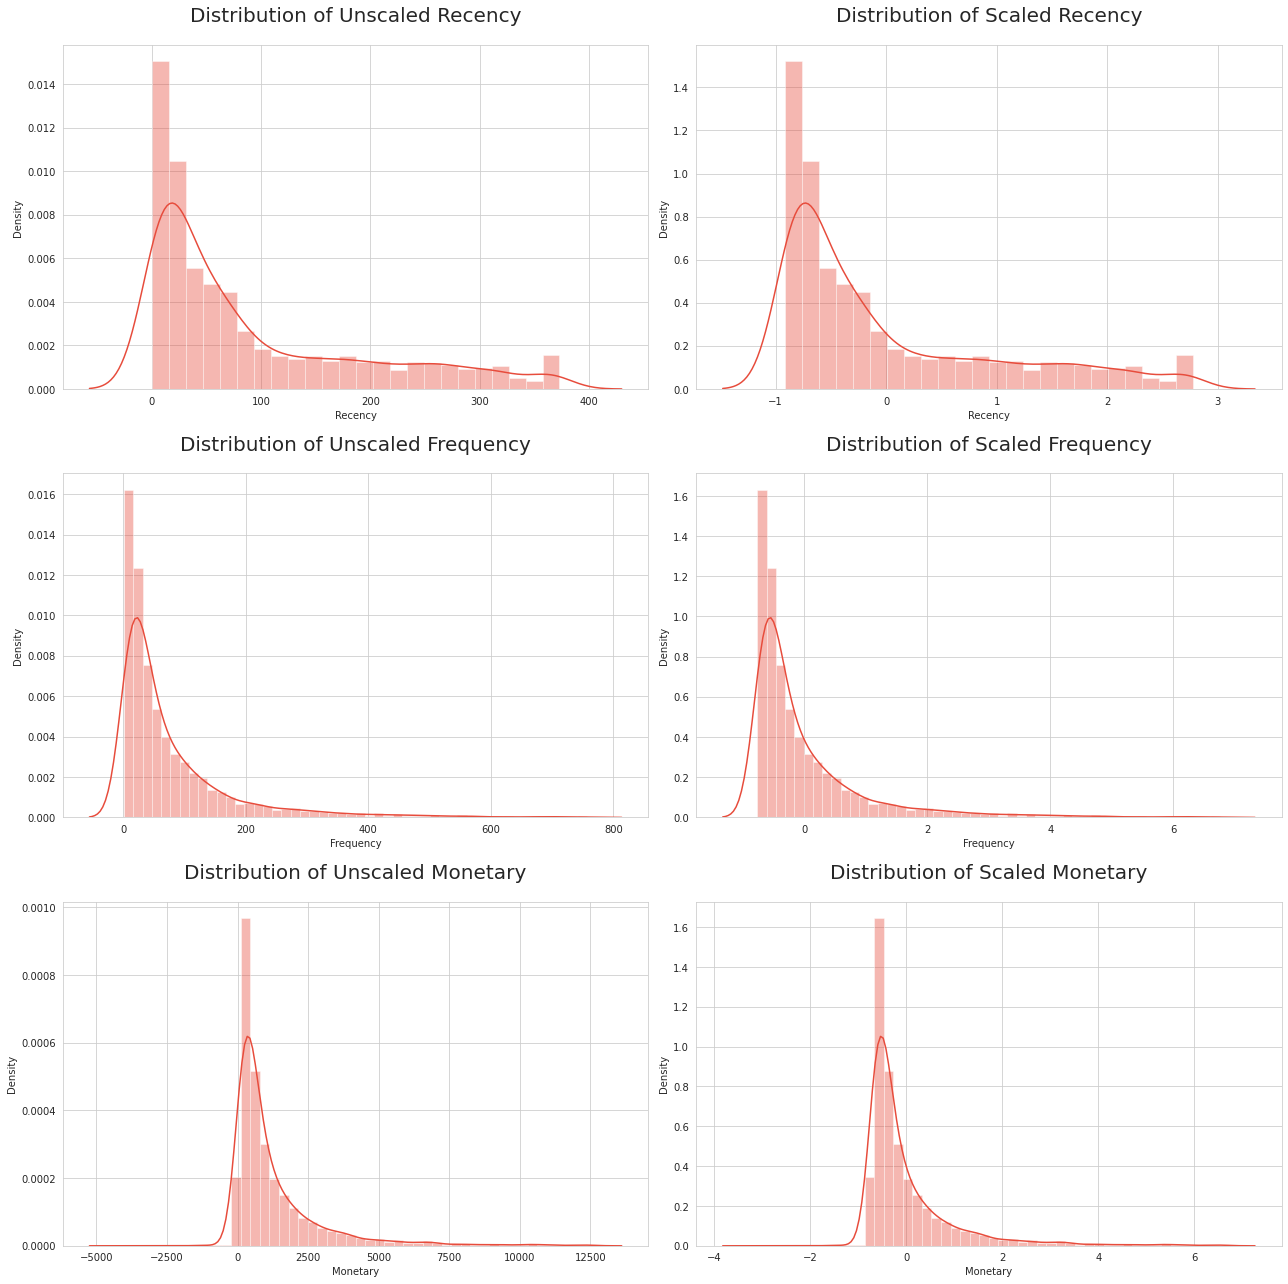

In [83]:
cont_features = ['Recency', 'Frequency', 'Monetary']


fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(18,18))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cont_features):
    sns.distplot(rfm[feature],  hist=True, color='#e74c3c', ax=ax[i][0])    
    sns.distplot(rfm_df_scaled[feature], hist=True, color='#e74c3c', ax=ax[i][1])
    
    ax[i][0].set_title(f'Distribution of Unscaled {feature}', size=20, y=1.05)
    ax[i][1].set_title(f'Distribution of Scaled {feature}', size=20, y=1.05)
    
plt.tight_layout() 

---
<a id='model'></a>
## Model

### K-Means Clustering


The K-means clustering is one of the simplest and popular unsupervised machine learning algorithms in which every indiviual sample in a dataset is assigned to exactly one cluster. The objective of K-Means clustering is to minimize total intra-cluster variance which is known as Sum of Squared Distances - SSD

The work flow of K-means is thus:

* **k points(means)** are initialized in a random order.
* Each item is categorized(grouped) to its closest mean and **centroid**, the metric for  is Euclidean distance.
* Next, the dat points of the centers are recalculated and updated.
* The process is repeated for a given number of iterations.
* In the end **centroids** & **clusters**(k's;groups of items) are formed.


### Silhouette Analysis

Silhouette analysis can be used to study the separation distance between the resulting clusters, a measure of how close each point in one cluster is to points in the neighboring clusters.




A silhouette score range is between -1 & 1.

- A score tending towards 1 tells that the data point is very similar to other data points in the cluster,
- A score of 0
- A score tending towards -1 tells that the data point is not similar to the data points in its cluster.

In [84]:
from sklearn.metrics import silhouette_score as SS

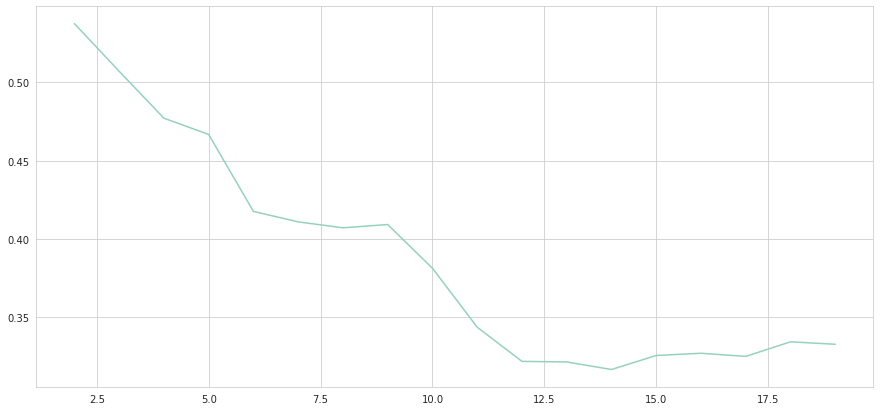

In [85]:
sse_ = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k).fit(rfm_df_scaled)
    sse_.append([k, SS(rfm_df_scaled, kmeans.labels_)])
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

### Sum of Squared Distances

SSE or cluster inertia is the within/intra-cluster sum of squared errors. 

So, the objective of K-Means clustering is to minimize total intra-cluster variance, or, the squared error function:



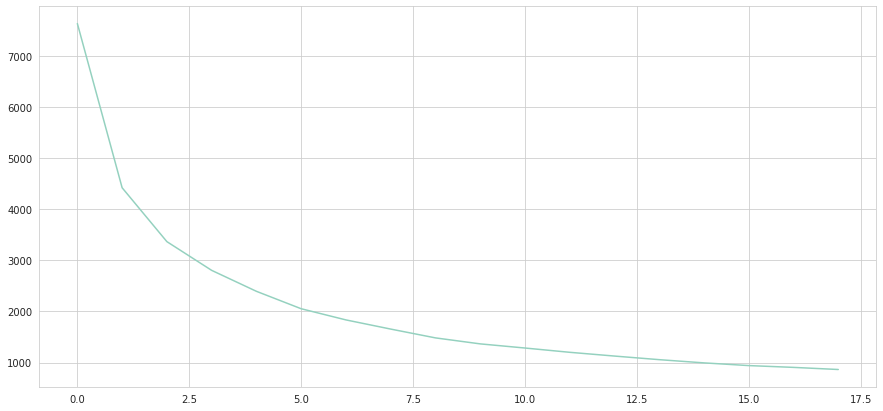

In [86]:
# sum of squared distances
ssd_ = []
for cluster_num in list(range(2,20)):
    model_clusters = KMeans(n_clusters = cluster_num, max_iter=100)
    model_clusters.fit(rfm_df_scaled)
    ssd_.append(model_clusters.inertia_)

plt.plot(ssd_)

### The Elbow method
#### Finding the optimal number of k points

In [87]:
from yellowbrick.cluster import KElbowVisualizer

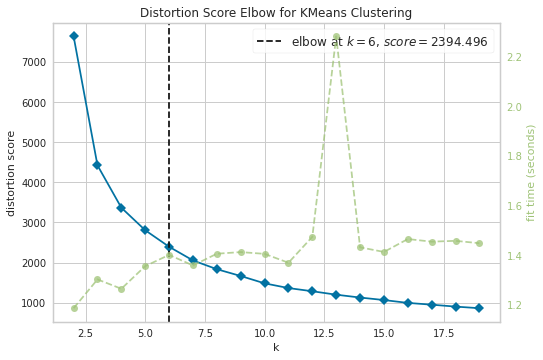

<Figure size 576x396 with 0 Axes>

In [88]:
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,20))
visu.fit(rfm_df_scaled)
visu.poof()
plt.tight_layout()

*Instantiating K-means*

In [89]:
# k-means with six clusters
kmeans = KMeans(n_clusters=6)

*Fit data*

In [90]:
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=6)

*Label*

In [91]:
clusters = kmeans.labels_

*Cluster center vectors*

In [92]:
kmeans.cluster_centers_

array([[-0.73672872,  3.70352016,  1.31363103],
       [-0.53726724, -0.36772243, -0.35871128],
       [-0.62082731,  0.71526182,  0.64507795],
       [-0.69488296,  1.76013282,  3.57096815],
       [ 2.02841114, -0.55059709, -0.5397707 ],
       [ 0.68915528, -0.45357391, -0.43532424]])

In [93]:
rfm_kmeans = rfm_df_scaled.copy()
rfm_kmeans["Cluster_no"] = clusters

customers_and_their_clusters = pd.DataFrame({"Cluster Number": (clusters), 'Recency' : rfm['Recency'], 'Frequency' : rfm_df['Frequency'], 'Monetary' : rfm_df['Monetary'], 'Segment' : rfm['Customer Segment']})

customers_and_their_clusters.sample(3)

,Cluster Number,Recency,Frequency,Monetary,Segment
Customer ID,,,,,
16339.0,4,283,20,109.95,Hibernating
16680.0,1,42,10,183.70,About to Sleep
17502.0,1,8,28,689.10,Potential Loyalists


In [94]:
clusters_grouped = customers_and_their_clusters.groupby("Cluster Number").agg({"Cluster Number":"count"})
clusters_grouped.rename({'Cluster Number':'Customer count'}, axis=1, inplace=True)
clusters_grouped.T

Cluster Number,0,1,2,3,4,5
Customer count,127,1881,785,178,606,713


In [95]:
n  = customers_and_their_clusters.groupby(['Cluster Number'])[['Recency', 'Frequency', 'Monetary']].agg(['mean','std'])
n.T

Cluster Number            0           1            2            3           4  \
Recency   mean    18.188976   38.257310    29.894268    22.415730  297.282178   
          std     25.779816   27.122883    32.822307    39.660511   44.214480   
Frequency mean   449.551181   40.507709   149.450955   254.247191   22.160066   
          std    122.740448   28.928894    58.220928   131.345732   24.483135   
Monetary  mean  3488.961811  647.323675  2355.752129  7326.181629  340.072673   
          std   1565.419145  465.447926  1010.045453  2180.819177  421.841165   

Cluster Number           5  
Recency   mean  161.838710  
          std    36.888087  
Frequency mean   31.670407  
          std    30.224942  
Monetary  mean  515.909663  
          std   521.801578

### Model Evaluation

#### The confusion matrix & classification report

In [96]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(customers_and_their_clusters['Cluster Number'],clusters))
print(classification_report(customers_and_their_clusters['Cluster Number'],clusters))

[[ 127    0    0    0    0    0]
 [   0 1881    0    0    0    0]
 [   0    0  785    0    0    0]
 [   0    0    0  178    0    0]
 [   0    0    0    0  606    0]
 [   0    0    0    0    0  713]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00      1881
           2       1.00      1.00      1.00       785
           3       1.00      1.00      1.00       178
           4       1.00      1.00      1.00       606
           5       1.00      1.00      1.00       713

    accuracy                           1.00      4290
   macro avg       1.00      1.00      1.00      4290
weighted avg       1.00      1.00      1.00      4290



 A plotly representation of the clusters

In [97]:
import plotly.express as px
fig = px.scatter_3d(rfm_kmeans, x=rfm_kmeans["Recency"], y=rfm_kmeans["Frequency"], z=rfm_kmeans["Monetary"], 
                    color=rfm_kmeans["Cluster_no"])
fig

<AxesSubplot:xlabel='Cluster_no', ylabel='Recency'>

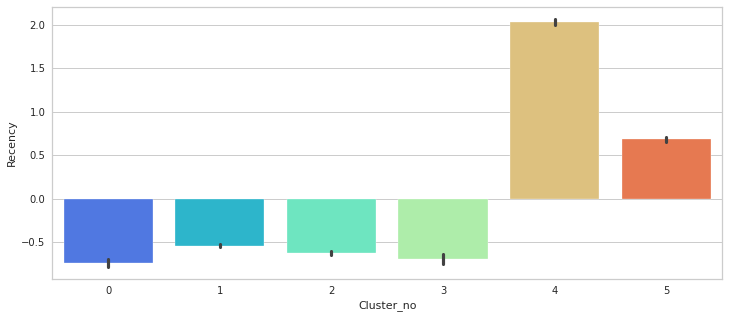

In [98]:

plt.rcParams['figure.figsize'] = [12,5]
sns.barplot(x='Cluster_no', y='Recency', data=rfm_kmeans, palette='rainbow')

<AxesSubplot:xlabel='Cluster_no', ylabel='Frequency'>

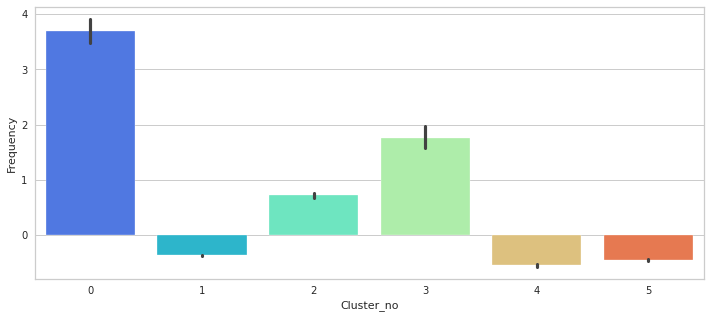

In [99]:
sns.barplot(x='Cluster_no', y='Frequency', data=rfm_kmeans, palette='rainbow')

<AxesSubplot:xlabel='Cluster_no', ylabel='Monetary'>

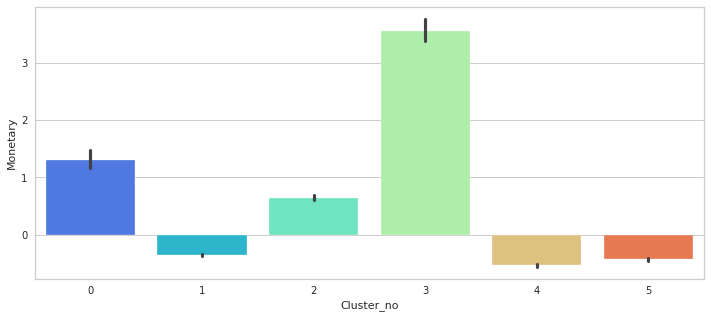

In [100]:
sns.barplot(x='Cluster_no', y='Monetary', data=rfm_kmeans, palette='rainbow')

---
<a id='conclusions'></a>
### Conclusions
- About 611,342.09 was lost to cancelled and failed purchases.
- Customers in cluster 0 are the most loyal
- Customers in cluster 3 are important to revenue generated
---
<a id='possible-solutions'></a>
### Solution and Suggestions
- Customers in cluster 0 and 3 respectively may be given discounts to promote their loyalty.
- Customers in clusters 1,4,5 should be targets of marketing strategies and personalized ads.